In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

from scipy.stats import wilcoxon

sns.set_style("whitegrid")

### Read in samples for origin ARS316, to set up the annotation of the nucleosome areas

## Wildtype

In [5]:
load_dir =  "ARS316"

In [6]:
ls ARS316/

ARS316_80bp.txt
ARS316_disw2_rep1_301READS.csv
ARS316_disw2_rep1_780READS.csv
ARS316_disw2_rep1_780READS_noNA.csv
ARS316_disw2_rep2_301READS.csv
ARS316_disw2_rep2_780READS.csv
ARS316_disw2_rep2_780READS_noNA.csv
ARS316_p_values_avg_feature_methylation.csv
ARS316_pooled_samples_two-sided-test.csv
ARS316_separate_replicates_two-sided-test.csv
ARS316_smoothed_average_methylation_winsize_30.csv
ARS316_smoothed_fold_changes_winsize_30.csv
DIES6_ALL_REP1_ARS316_end_LexA.txt
DIES6_ARS316_REP2_301READS.csv
Features from ARS316_end_LexA  (31 .. 1280).txt
coordinates_ARS316.txt
mat_Megalodon_repII_ARS316_end_LexA.txt
plots/
unused_files/
wt_mat_Megalodon_repIII_ARS316_end_LexA.txt
wt_mat_Megalodon_repIII_ARS316_end_LexA_301READS.txt


In [7]:
wt_rep3 = np.loadtxt(load_dir + "/wt_mat_Megalodon_repIII_ARS316_end_LexA.txt")

#replicate 2
wt_rep2 = np.loadtxt(load_dir + "/mat_Megalodon_repII_ARS316_end_LexA.txt")

#feature annotation
#anno = pd.read_csv(load_dir + "/Features_from_ARS316_end_LexA _(31 .. 1280).txt", sep  = "\t", 
#                          header = None, index_col = 0)
#anno.columns = ["position", "length"]
#anno = pd.read_csv(load_dir + "/coordinates_ARS316.txt", sep  = "\t", 
#                          header = None, index_col = 0)

anno = pd.read_csv(load_dir + "/ARS316_80bp.txt", sep  = "\t", 
                          header = None, index_col = 0)
anno.columns = ["position"]

anno.index = anno.index.astype("string")
anno.index = anno.index.str.strip()

anno["pos_start"] = anno.position.str.split("-").str[0].astype(int) -1
anno["pos_stop"] = anno.position.str.split("-").str[1].astype(int) -1

anno["length"] = anno.pos_stop - anno.pos_start

In [8]:
anno

,position,pos_start,pos_stop,length
0,,,,
-3 NS,75-155,74,154,80
-2L,200-220,199,219,20
-2NS,300-380,299,379,80
-1L,400-420,399,419,20
-1NS,475-555,474,554,80
ARS316,625-705,624,704,80
+1ns,750-830,749,829,80
+2ns,880-960,879,959,80
+2L,1025-1050,1024,1049,25


In [9]:
wt_rep2.shape[1] == wt_rep3.shape[1]

True

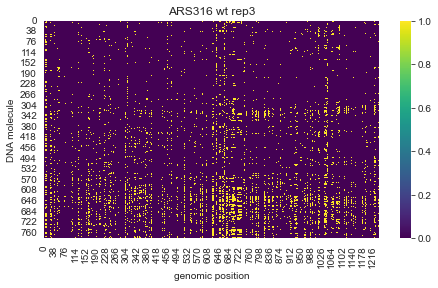

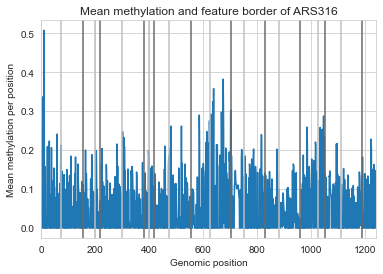

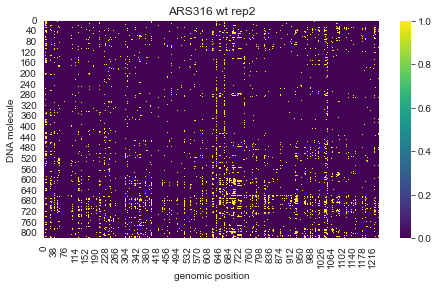

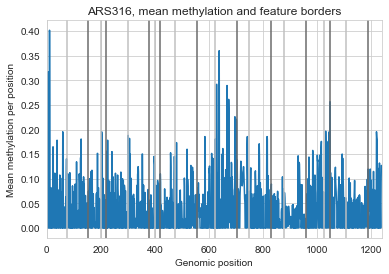

In [10]:
#plot the raw data:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + " wt rep3")
plt.show()

#and the bulk data:
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep3.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title("Mean methylation and feature border of " + load_dir)
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

#wildtype replicate 2:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + " wt rep2")
plt.show()

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep2.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title(load_dir + ", mean methylation and feature borders")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

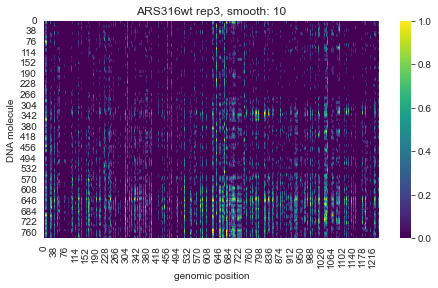

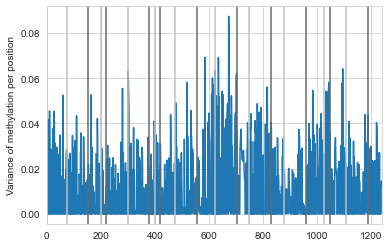

In [11]:
smooth_window = 10

def smooth(array):
        return np.convolve(array, np.ones(smooth_window)/smooth_window, mode = "same")
    
wt_rep3_smooth = np.apply_along_axis(smooth, 0, wt_rep3)
    
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3_smooth, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + "wt rep3, smooth: " + str(smooth_window))
plt.show()

sns.lineplot(x = range(wt_rep3_smooth.shape[1]), 
                 y = wt_rep3_smooth.std(axis = 0)**2
                )
plt.ylabel("Variance of methylation per position")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

In [12]:
#sns.lineplot(x = wt_rep3.shape[1], y = 100 * wt_rep3.cumsum(axis = 0)wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1])

#wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :].shape
100 * wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1]

array([8.87812752, 0.        , 0.        , ..., 0.        , 7.26392252,
       9.28167877])

In [13]:
#this computes the percent of methylation at a specific base
wt_rep3.cumsum(axis = 0)/wt_rep3.shape[1]

#as a measure for the heterogeneity, try the entropy:
# alternatively, try: from scipy.stats import entropy

def entropy(labels, base=None):
    base = 2 if base is None else base
    _ ,counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()

    return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

#https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python

<AxesSubplot:title={'center':'ARS316 wt rep3, entropy per position'}, ylabel='entropy'>

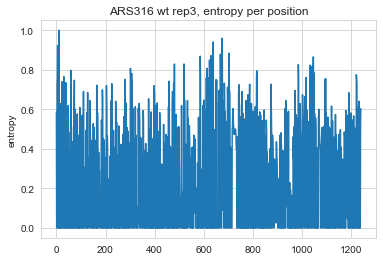

In [14]:
g = sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.apply_along_axis(entropy, 0, wt_rep3))
g.set_ylabel("entropy")
g.set_title(load_dir + " wt rep3, " + "entropy per position")
#g.set_xticks(range(0, ARS305_wt.shape[1], 50))
g

In [15]:
entropy_wt_rep3 = np.apply_along_axis(entropy, 0, wt_rep3)
entropy_wt_rep3.min(), entropy_wt_rep3.max(), np.count_nonzero(entropy_wt_rep3)

(-0.0, 0.9998292601233936, 657)

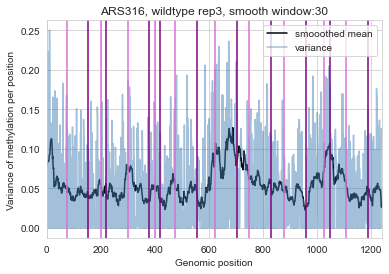

In [16]:
N = 30

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(N)/N, mode ="same"),
             color = "black", label = "smooothed mean")
#plt.ylabel("Mean methylation over sample")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir +  ", wildtype rep3, smooth window:" + str(N))


sns.lineplot(x = range(wt_rep3.shape[1]), 
            y = wt_rep3.std(axis = 0)**2, color = "steelblue", alpha = 0.5,
            label = "variance"
            )
plt.ylabel("Variance of methylation per position")
plt.xlabel("Genomic position")
#plt.axvline(62, color = "purple", label = "border")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "orchid")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "purple")

## Load data for mutant dies6

(83, 1239)


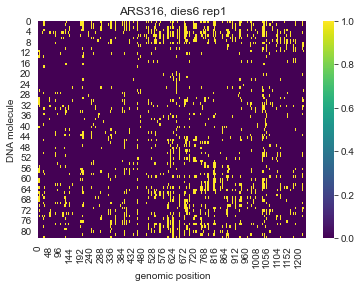

(301, 1239)


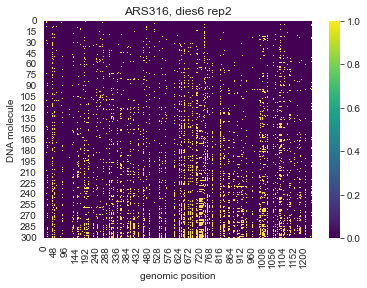

In [17]:
dies6_rep1 = np.loadtxt(load_dir + "/DIES6_ALL_REP1_ARS316_end_LexA.txt")
print(dies6_rep1.shape)

sns.heatmap(dies6_rep1, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep1.shape[1])
plt.title(load_dir + ", dies6 rep1")
plt.show()

dies6_rep2 = np.genfromtxt(load_dir + "/DIES6_ARS316_REP2_301READS.csv", dtype = int, delimiter = ",")
print(dies6_rep2.shape)

sns.heatmap(dies6_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep2.shape[1])
plt.title(load_dir + ", dies6 rep2")
plt.show()

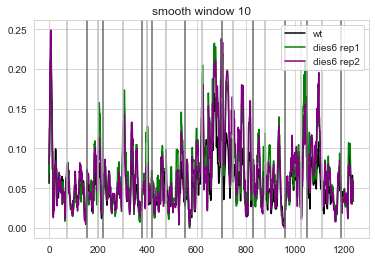

(119189.0, 3.612280301248399e-98)

In [18]:
#smooth = 1

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "dies6 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "dies6 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

wt_rep3_smooth_mean = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep1_smooth_mean = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep2_smooth_mean = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((wt_rep3_smooth_mean.reshape(1, wt_rep3.shape[1]), 
                        dies6_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        dies6_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                              axis = 0)

from scipy.stats import wilcoxon

w, p = wilcoxon(means[0,:], means[1,:], alternative = "two-sided")
w,p

In [19]:
#statistical test to compare replicates of the mutants: 
wilcoxon(dies6_rep1.mean(axis = 0), 
         dies6_rep2.mean(axis = 0), alternative = "two-sided")

WilcoxonResult(statistic=92016.0, pvalue=0.017348296472827325)

## Load data for mutant disw2

(780, 1239)


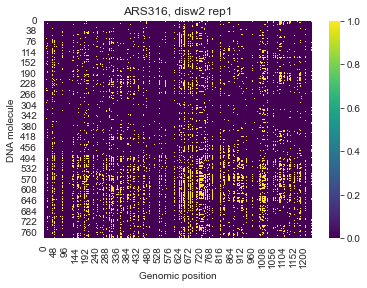

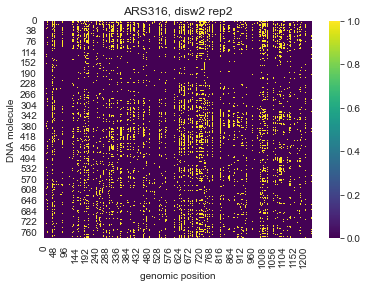

In [20]:
disw2_rep1 = np.genfromtxt(load_dir + "/ARS316_disw2_rep1_780READS_noNA.csv", dtype = int,
                                 delimiter = ",")
print(disw2_rep1.shape)

sns.heatmap(disw2_rep1, cmap = "viridis")
plt.xlabel("Genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep1.shape[1])
plt.title(load_dir + ", disw2 rep1")
plt.show()

disw2_rep2 = np.genfromtxt(load_dir + "/ARS316_disw2_rep2_780READS_noNA.csv", dtype = int, delimiter = ",")
disw2_rep2.shape

sns.heatmap(disw2_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep2.shape[1])
plt.title(load_dir + ", disw2 rep2")
plt.show()

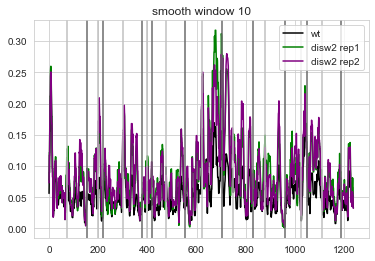

In [21]:
#smooth = 1

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "disw2 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "disw2 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

In [22]:
# calculate the mean over all molecules and smooth with window size "smooth"

disw2_rep1_smooth_mean = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
disw2_rep2_smooth_mean = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((means, 
                        disw2_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        disw2_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                        axis = 0)

w, p = wilcoxon(disw2_rep1.mean(axis = 0),
                disw2_rep2.mean(axis = 0), alternative = "two-sided")
w,p

(103082.0, 0.9254377042917336)

### Min-max normalise each experiment and pool replicates

In [23]:
wt_rep3_minmax = wt_rep3.mean(axis = 0)/wt_rep3.mean(axis = 0).max()
wt_rep2_minmax = wt_rep2.mean(axis = 0)/wt_rep2.mean(axis = 0).max()

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1.mean(axis = 0)/dies6_rep1.mean(axis = 0).max()
dies6_rep2_minmax = dies6_rep2.mean(axis = 0)/dies6_rep2.mean(axis = 0).max()

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1.mean(axis = 0)/disw2_rep1.mean(axis = 0).max()
disw2_rep2_minmax = disw2_rep2.mean(axis = 0)/disw2_rep2.mean(axis = 0).max()

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

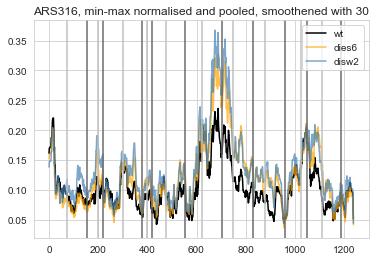

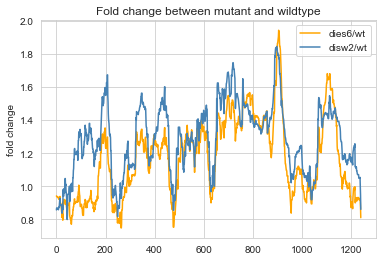

In [24]:
N=30

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"), #wt_min_max
             color = "black", 
            label = "wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), #dies6_min_max
             color = "orange", alpha = 0.7,
            label = "dies6")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), #disw2_min_max
            color = "steelblue", alpha = 0.7,
            label = "disw2")
plt.title(load_dir +  ", min-max normalised and pooled, smoothened with " + str(N)) #pooled and min-max normalised
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()
#plt.savefig(load_dir + "/plots/average_smoothed_methylation_by_condition.png")

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "orange", 
             label = "dies6/wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "steelblue",
             label = "disw2/wt")
plt.ylabel("fold change")
plt.title("Fold change between mutant and wildtype")
plt.show()

## Condense segment information for statistical testing of methylation per feature window for pooled replicates

In [25]:
segments = anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [pooled_dies6[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["dies6_mean"] = pd.Series(array_list, index = segments.index)

#disw2 mutant

array_list = [pooled_disw2[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["disw2_mean"] = pd.Series(array_list, index = segments.index)

In [26]:
segments["p_value_dies6"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments.drop(segments.columns[3:6], axis =1, inplace = True)

/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small

In [27]:
#segments.to_csv(load_dir + "/ARS316_pooled_samples_two-sided-test.csv")

In [28]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the dies6 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_dies6"] < pvalue)]

       Which sites have a different mean methylation in the dies6 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
0,,,,,
-3 NS,74,154,80,0.022312,8.765864e-03
-2NS,299,379,80,0.007022,2.262183e-04
-1NS,474,554,80,0.014886,7.220315e-03
ARS316,624,704,80,0.005482,3.343942e-03
+1ns,749,829,80,0.000019,5.455485e-06
+2ns,879,959,80,0.000043,9.171571e-07
+3ns,1109,1189,80,0.001994,6.669963e-06


In [29]:
#Regions significant for disw2:
print("       Which sites have a different mean methylation in the disw2 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_disw2"] < pvalue)]

       Which sites have a different mean methylation in the disw2 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
0,,,,,
-3 NS,74,154,80,0.022312,8.765864e-03
-2L,199,219,20,0.028417,9.344113e-03
-2NS,299,379,80,0.007022,2.262183e-04
-1NS,474,554,80,0.014886,7.220315e-03
ARS316,624,704,80,0.005482,3.343942e-03
+1ns,749,829,80,0.000019,5.455485e-06
+2ns,879,959,80,0.000043,9.171571e-07
+3ns,1109,1189,80,0.001994,6.669963e-06


### Compare pooled wildtype to mutant replicates separately and perform statistical test, then filter regions

In [30]:
segments = anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [dies6_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [dies6_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep2"] = pd.Series(array_list, index = segments.index)


#disw2 mutant
array_list = [disw2_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [disw2_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep2"] = pd.Series(array_list, index = segments.index)

In [31]:
#perform statistical test
segments["p_value_dies6_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_dies6_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_disw2_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]
test_higher = segments.iloc[:, :8]
segments.drop(segments.columns[3:8], axis =1, inplace = True)

/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small

In [32]:
#segments.to_csv(load_dir + "/ARS316_separate_replicates_two-sided-test.csv")

In [33]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the dies6 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_dies6_rep1"] < pvalue) &
            (segments["p_value_dies6_rep2"] < pvalue)]

       Which sites have a different mean methylation in the dies6 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
-2L,199,219,20,0.021824,0.021824,0.021824,5.062032e-03
-2NS,299,379,80,0.020213,0.009576,0.001694,3.429140e-05
ARS316,624,704,80,0.005282,0.008786,0.003476,2.858923e-03
+1ns,749,829,80,0.000133,0.000005,0.000031,4.751566e-06
+2ns,879,959,80,0.000424,0.000033,0.000010,2.920913e-08
+3ns,1109,1189,80,0.002641,0.001624,0.000013,3.538757e-06


In [34]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the disw2 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_disw2_rep1"] < pvalue) &
            (segments["p_value_disw2_rep2"] < pvalue)]

       Which sites have a different mean methylation in the disw2 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
-2L,199,219,20,0.021824,0.021824,0.021824,5.062032e-03
-2NS,299,379,80,0.020213,0.009576,0.001694,3.429140e-05
ARS316,624,704,80,0.005282,0.008786,0.003476,2.858923e-03
+1ns,749,829,80,0.000133,0.000005,0.000031,4.751566e-06
+2ns,879,959,80,0.000424,0.000033,0.000010,2.920913e-08
+3ns,1109,1189,80,0.002641,0.001624,0.000013,3.538757e-06


In [35]:
#Repeat this test for the case that methylation in one fragment is higher than in wildtype:

test_higher["p_value_dies6_rep1"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"dies6_mean_rep1"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_dies6_rep2"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"dies6_mean_rep2"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep1"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"disw2_mean_rep1"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep2"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"disw2_mean_rep2"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher.drop(test_higher.columns[3:8], axis =1, inplace = True)

/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/karoline.holler/anaconda3/envs/nanopore_methylation/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small

In [36]:
test_higher

,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
-3 NS,74,154,80,0.985278,0.891882,0.026462,2.698352e-03
-2L,199,219,20,0.010912,0.010912,0.010912,2.531016e-03
-2NS,299,379,80,0.010107,0.004788,0.000847,1.714570e-05
-1L,399,419,20,0.013996,0.088148,0.013996,8.980239e-03
-1NS,474,554,80,0.006245,0.028652,0.016964,4.094112e-04
ARS316,624,704,80,0.002641,0.004393,0.001738,1.429461e-03
+1ns,749,829,80,0.000066,0.000003,0.000015,2.375783e-06
+2ns,879,959,80,0.000212,0.000016,0.000005,1.460456e-08
+2L,1024,1049,25,0.275462,0.764831,0.487480,2.548987e-01


In [37]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the dies6 mutant?")
test_higher.loc[(test_higher["p_value_dies6_rep1"] < pvalue) & 
         (test_higher["p_value_dies6_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the dies6 mutant?


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
-2L,199,219,20,0.010912,0.010912,0.010912,2.531016e-03
-2NS,299,379,80,0.010107,0.004788,0.000847,1.714570e-05
ARS316,624,704,80,0.002641,0.004393,0.001738,1.429461e-03
+1ns,749,829,80,0.000066,0.000003,0.000015,2.375783e-06
+2ns,879,959,80,0.000212,0.000016,0.000005,1.460456e-08
+3ns,1109,1189,80,0.001320,0.000812,0.000007,1.769379e-06


In [38]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the disw2 mutant?")
test_higher.loc[(test_higher["p_value_disw2_rep1"] < pvalue) & 
         (test_higher["p_value_disw2_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the disw2 mutant?


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
-2L,199,219,20,0.010912,0.010912,0.010912,2.531016e-03
-2NS,299,379,80,0.010107,0.004788,0.000847,1.714570e-05
-1L,399,419,20,0.013996,0.088148,0.013996,8.980239e-03
-1NS,474,554,80,0.006245,0.028652,0.016964,4.094112e-04
ARS316,624,704,80,0.002641,0.004393,0.001738,1.429461e-03
+1ns,749,829,80,0.000066,0.000003,0.000015,2.375783e-06
+2ns,879,959,80,0.000212,0.000016,0.000005,1.460456e-08
+3ns,1109,1189,80,0.001320,0.000812,0.000007,1.769379e-06


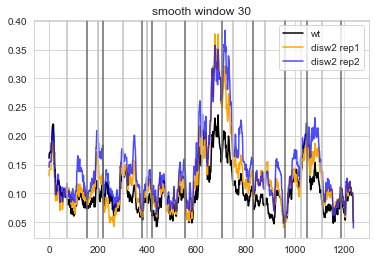

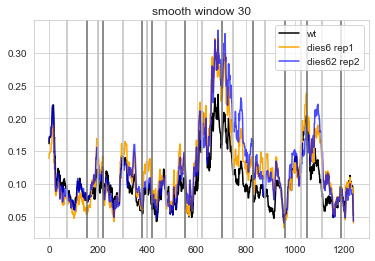

In [39]:
# How does that look over the whole sequence?
smooth_width = 30

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "orange", label = "disw2 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "blue", alpha = 0.7, label = "disw2 rep2")
plt.title("smooth window " + str(smooth_width))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "orange", label = "dies6 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "blue", alpha = 0.7, label = "dies62 rep2")
plt.title("smooth window " + str(smooth_width))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

In [40]:
#Display the mean methylation per feature

def condense_features(array, anno):
    output = np.empty(array.shape[0],)
    for index in anno.index:
        feature_array = array[:, anno.loc[index, "pos_start"]: anno.loc[index, "pos_stop"]]
        means_by_feature = np.apply_along_axis(np.mean, 1, feature_array)
        #means_by_feature = np.apply_along_axis(np.std, 1, feature_array) #to calculate variance
        output = np.column_stack((output, means_by_feature))
    return output[:, 1:]

In [41]:
#try the mean methylation on smoothed data per window

"""
smooth_window = 10

def smooth(array):
        return np.convolve(array, np.ones(smooth_window)/smooth_window, mode = "same")
    
wt_rep3_smooth = np.apply_along_axis(smooth, 0, wt_rep3)
dies6_rep2_smooth = np.apply_along_axis(smooth, 0, dies6_rep2)
disw2_rep1_smooth = np.apply_along_axis(smooth, 0, disw2_rep1)

wt_rep3_feat_me = condense_features(wt_rep3_smooth, anno)
dies6_rep2_feat_me = condense_features(dies6_rep2_smooth, anno)
disw2_rep1_feat_me = condense_features(disw2_rep1_smooth, anno)
"""

'\nsmooth_window = 10\n\ndef smooth(array):\n        return np.convolve(array, np.ones(smooth_window)/smooth_window, mode = "same")\n    \nwt_rep3_smooth = np.apply_along_axis(smooth, 0, wt_rep3)\ndies6_rep2_smooth = np.apply_along_axis(smooth, 0, dies6_rep2)\ndisw2_rep1_smooth = np.apply_along_axis(smooth, 0, disw2_rep1)\n\nwt_rep3_feat_me = condense_features(wt_rep3_smooth, anno)\ndies6_rep2_feat_me = condense_features(dies6_rep2_smooth, anno)\ndisw2_rep1_feat_me = condense_features(disw2_rep1_smooth, anno)\n'

In [42]:
#condense methylation by feature 
wt_rep3_feat_me = condense_features(wt_rep3, anno)
wt_rep2_feat_me = condense_features(wt_rep2, anno)

wt_pool = np.concatenate((wt_rep3_feat_me, wt_rep2_feat_me), axis = 0)

dies6_rep1_feat_me = condense_features(dies6_rep1, anno)
dies6_rep2_feat_me = condense_features(dies6_rep2, anno)

dies6_pool = np.concatenate((dies6_rep1_feat_me, dies6_rep2_feat_me), axis= 0)

disw2_rep1_feat_me = condense_features(disw2_rep1, anno)
disw2_rep2_feat_me = condense_features(disw2_rep2, anno)

disw2_pool = np.concatenate((disw2_rep1_feat_me, disw2_rep2_feat_me), axis = 0)

Comparing replicates


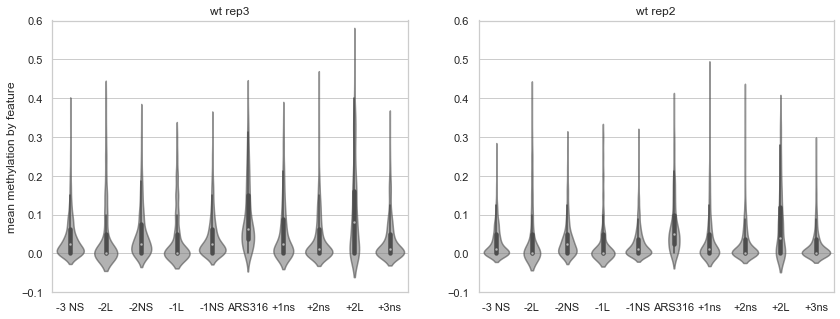

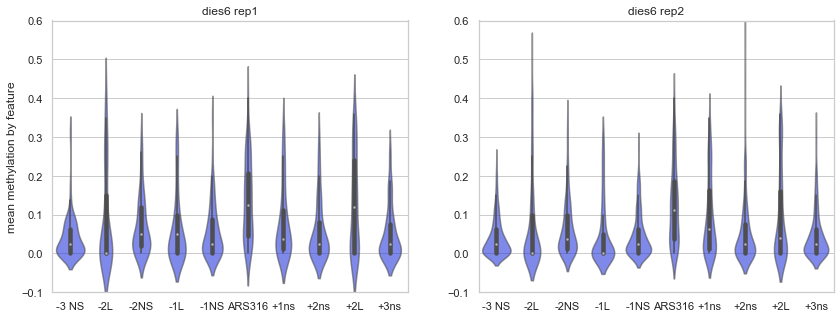

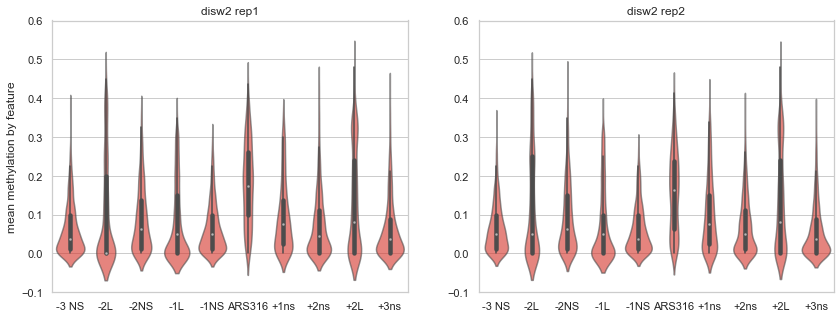

In [43]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

print("Comparing replicates")
#wt
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))

sns.violinplot(data = wt_rep3_feat_me, axis = 1, color = "grey", ax=ax1)
ax1.set_title("wt rep3")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-0.1,0.6)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = wt_rep2_feat_me, axis = 1, color = "grey", ax=ax2)
ax2.set_title("wt rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-0.1,0.6)
plt.setp(ax2.collections, alpha = 0.6)
plt.savefig(load_dir + "/plots/ARS316_methylyation_by_feature_wt.tif")
plt.show()

#dies6
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = dies6_rep1_feat_me, axis = 1, color = "#0a22fa", ax=ax1)
ax1.set_title("dies6 rep1")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-0.1,0.6)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = dies6_rep2_feat_me, axis = 1, color = "#0a22fa", ax=ax2)
ax2.set_title("dies6 rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-0.1,0.6)
plt.setp(ax2.collections, alpha = 0.6)
plt.savefig(load_dir + "/plots/ARS316_methylyation_by_feature_dies6.tif")
plt.show()

#disw2
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = disw2_rep1_feat_me, axis = 1, color = "#f2180c", ax=ax1)
ax1.set_title("disw2 rep1")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-0.1,0.6)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = disw2_rep2_feat_me, axis = 1, color = "#f2180c", ax=ax2)
ax2.set_title("disw2 rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-0.1,0.6)
plt.setp(ax2.collections, alpha = 0.6)
plt.savefig(load_dir + "/plots/ARS316_methylyation_by_feature_disw2.tif")
plt.show()

In [188]:
#Combine the violinplots into one plot per replicate:
#for each feature, plot wt and mutants next to each other

#transfer array to dataframe, melt that into the long form and assign a catergory "condition"
feat_me_wt_rep3 = pd.DataFrame(wt_rep3_feat_me, columns = anno.index)
feat_me_wt_rep3["molecule"] = feat_me_wt_rep3.index
feat_me_wt_rep3_melt = pd.melt(feat_me_wt_rep3, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_rep3_melt["condition"] = "wt rep3"

feat_me_wt_pool = pd.DataFrame(wt_pool, columns = anno.index)
feat_me_wt_pool["molecule"] = feat_me_wt_pool.index
feat_me_wt_melt = pd.melt(feat_me_wt_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_melt["condition"] = "wt"


#the same for dies6
feat_me_dies6_rep2 = pd.DataFrame(dies6_rep2_feat_me, columns = anno.index)
feat_me_dies6_rep2["molecule"] = feat_me_dies6_rep2.index

feat_me_dies6_rep2_melt = pd.melt(feat_me_dies6_rep2, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_rep2_melt["condition"] = "dies6"

feat_me_dies6_pool = pd.DataFrame(dies6_pool, columns = anno.index)
feat_me_dies6_pool["molecule"] = feat_me_dies6_pool.index
feat_me_dies6_melt = pd.melt(feat_me_dies6_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_melt["condition"] = "dies6"

#the same for disw2
feat_me_disw2_rep1 = pd.DataFrame(disw2_rep1_feat_me, columns = anno.index)
feat_me_disw2_rep1["molecule"] = feat_me_disw2_rep1.index

feat_me_disw2_rep1_melt = pd.melt(feat_me_disw2_rep1, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_rep1_melt["condition"] = "disw2"

feat_me_disw2_pool = pd.DataFrame(disw2_pool, columns = anno.index)
feat_me_disw2_pool["molecule"] = feat_me_disw2_pool.index
feat_me_disw2_melt = pd.melt(feat_me_disw2_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_melt["condition"] = "disw2"

#merge into one dataframe:
methylation_rep1 = pd.concat([feat_me_wt_melt, feat_me_dies6_melt, feat_me_disw2_melt])
methylation_rep1.rename(columns = {"value" : "mean methylation"}, inplace=True)

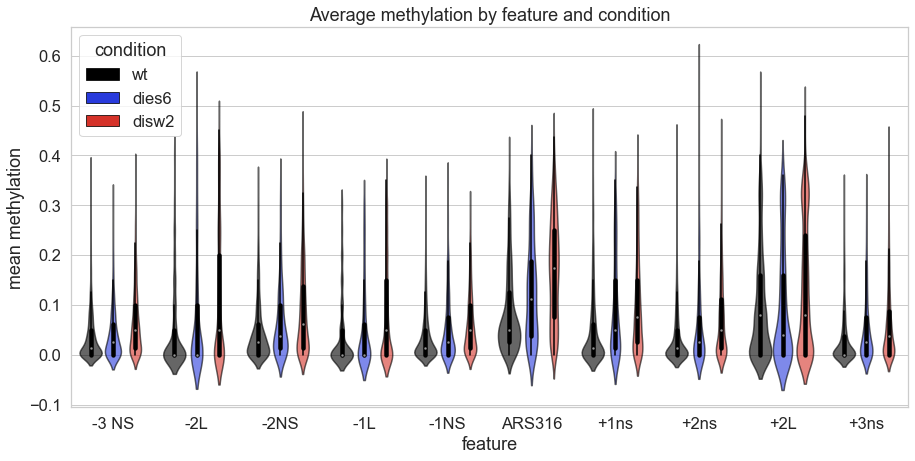

In [208]:
col_Anna = ["black", "#0a22fa", "#f2180c"]

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

plt.figure(figsize = (15,7))
ax = sns.violinplot(data = methylation_rep1, x="feature", y = "mean methylation", hue = "condition", 
                    palette = col_Anna)
plt.setp(ax.collections, alpha = 0.6)
#plt.ylabel("variance")
plt.title("Average methylation by feature and condition")
#plt.savefig(load_dir + "/plots/ARS316_pooled_av_methylation_by_feature_anno3.tif", dpi = 300)
plt.show()

#use , inner="point" in violinplot to display the datapoints. The default is a small boxplot.

In [209]:
from scipy.stats import mannwhitneyu

In [210]:
#Calculate p-values for the distributions in the violins using the mann-whitney U test

feature_pvalues = anno.drop(columns = "position")
feature_pvalues["dies6_rep2"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_rep2.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]
feature_pvalues["disw2_rep1"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_rep1.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]

feature_pvalues

,pos_start,pos_stop,length,dies6_rep2,disw2_rep1
0,,,,,
-3 NS,74,154,80,2.696919e-02,3.757925e-30
-2L,199,219,20,2.047491e-03,1.303496e-23
-2NS,299,379,80,2.928814e-06,3.697541e-32
-1L,399,419,20,1.548269e-02,3.406075e-25
-1NS,474,554,80,6.111363e-04,1.263283e-34
ARS316,624,704,80,1.983254e-10,7.216415e-99
+1ns,749,829,80,1.674002e-17,1.002490e-50
+2ns,879,959,80,3.186309e-05,4.824355e-40
+2L,1024,1049,25,1.673149e-01,3.476999e-09


In [211]:
feature_pvalues[feature_pvalues.dies6_rep2 >= 2.5e-2]

,pos_start,pos_stop,length,dies6_rep2,disw2_rep1
0,,,,,
-3 NS,74,154,80,0.026969,3.757925e-30
+2L,1024,1049,25,0.167315,3.476999e-09


In [212]:
feature_pvalues[feature_pvalues.disw2_rep1 >= 2.5e-2]

,pos_start,pos_stop,length,dies6_rep2,disw2_rep1
0,,,,,


In [213]:
#Calculate p-values for the distributions in the violins using the mann-whitney U test

feature_pvalues = anno.drop(columns = "position")
feature_pvalues["dies6_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]
feature_pvalues["disw2_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]

feature_pvalues

,pos_start,pos_stop,length,dies6_pool,disw2_pool
0,,,,,
-3 NS,74,154,80,2.194086e-02,2.611357e-55
-2L,199,219,20,1.242480e-04,1.191063e-51
-2NS,299,379,80,5.488800e-08,2.080271e-49
-1L,399,419,20,2.708012e-04,2.446993e-35
-1NS,474,554,80,4.359391e-05,1.054498e-49
ARS316,624,704,80,6.643342e-14,2.891520e-116
+1ns,749,829,80,1.202939e-19,2.731246e-79
+2ns,879,959,80,8.946375e-07,8.469204e-64
+2L,1024,1049,25,6.925165e-01,5.364444e-14


In [214]:
feature_pvalues[feature_pvalues.dies6_pool >= 2.5e-2]

,pos_start,pos_stop,length,dies6_pool,disw2_pool
0,,,,,
+2L,1024,1049,25,0.692516,5.364444e-14


In [215]:
feature_pvalues[feature_pvalues.disw2_pool >= 2.5e-2]

,pos_start,pos_stop,length,dies6_pool,disw2_pool
0,,,,,


In [205]:
#feature_pvalues.to_csv(load_dir + "/ARS316_p_values_avg_feature_methylation.csv")

In [46]:
#Exporting aggregated data for Anna to plot for the manuscript 
#31th May 2022

smooth = {"wt_pooled": np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep3": np.convolve(wt_rep3_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep2": np.convolve(wt_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep1": np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep2": np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_pooled": np.convolve(pooled_dies6, np.ones(smooth_width)/smooth_width, mode="same"),
         "disw2_rep1": np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_rep2": np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_pooled": np.convolve(pooled_disw2, np.ones(smooth_width)/smooth_width, mode="same")}


ARS316_smooth_30 = pd.DataFrame.from_dict(smooth)
ARS316_smooth_30.index = ARS316_smooth_30.index + 1
#ARS316_smooth_30.to_csv("ARS316/ARS316_smoothed_average_methylation_winsize_30.csv")

FC = {
    "dies6_pooled" : np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
    "disw2_pooled" : np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same")
}

ARS316_FCs = pd.DataFrame.from_dict(FC)
ARS316_FCs.index = ARS316_FCs.index + 1

#ARS316_FCs.to_csv("ARS316/ARS316_smoothed_fold_changes_winsize_30.csv")